<a href="https://colab.research.google.com/github/anamabo/SegmentWaterWithPaligemma/blob/main/finetune_paligemma_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetune Paligemma to segment water in satellite images


This Notebook is based on these Links:

* Roboflow notebook on how to use Paligemma for object detection: https://blog.roboflow.com/how-to-fine-tune-paligemma/

* [PaliGemma by Google: Train Model on Custom Detection Dataset](https://https://www.youtube.com/watch?v=OMBmVInx68M&t=511s)



# Importing the libraries needed

In [1]:
import cv2
from matplotlib import pyplot as plt
import os
import re

import json
import sys
from typing import Tuple, List
from google.colab import userdata

# JAX and related dependencies
import base64
import functools
import html
import io
import warnings

import jax
import jax.numpy as jnp
import numpy as np

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import kagglehub


# Access the data for the model

The original data has taken from Kaggle: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

However, some filtering was made to remove images with incorrect masks. The final set of images can be found [here](https://drive.google.com/drive/folders/1U9MkU1fU6uZQrbN5-SAvewOU4dITuhtj).

You can use this [GitHub repository](https://github.com/anamabo/medium-blogs/tree/main/SegmentWaterWithPaligemmaOnce) to obtain a dataset in JSONL format for Paligemma using the filtered images.

Once you have the file, update the data to your `content/` Drive folder.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
root_path = "/content/drive/MyDrive/paligemma_for_segmentation/"
data_path = os.path.join(root_path, "water_bodies/")

In [4]:
# See the JSONL files
!ls {data_path}*.jsonl

/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/test.jsonl
/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/train.jsonl


In [5]:
# See the content of one JSONL file
!head -n 1 {data_path}test.jsonl

{"image": "water_body_8689.jpg", "prefix": "segment water", "suffix": "<loc0822><loc0759><loc1001><loc1018><seg103><seg095><seg109><seg106><seg117><seg110><seg123><seg117><seg110><seg123><seg106><seg115><seg111><seg117><seg114><seg112> water; <loc0804><loc0991><loc0845><loc1018><seg101><seg126><seg102><seg125><seg103><seg126><seg104><seg125><seg105><seg124><seg105><seg127><seg102><seg127><seg101><seg126> water; <loc0402><loc0905><loc0512><loc1007><seg050><seg115><seg054><seg113><seg058><seg117><seg061><seg121><seg063><seg125><seg057><seg123><seg056><seg121><seg054><seg117> water; <loc0169><loc0021><loc0836><loc1013><seg077><seg125><seg030><seg071><seg029><seg058><seg040><seg063><seg049><seg026><seg073><seg009><seg084><seg049><seg091><seg088> water; <loc0004><loc0948><loc0050><loc0991><seg001><seg119><seg003><seg119><seg005><seg119><seg005><seg121><seg006><seg121><seg005><seg122><seg001><seg123><seg001><seg121> water"}


## Define some constants

In [6]:
# To save the fine-tuned model in Drive
# Note: you need at least 3GB of space in your Drive!
SAVE_MODEL = False

# Paligemma has been trained to handle images of different aspects ratios
# resized to 224x224 in the range [-1, 1]
NEW_IMAGE_SIZE = 224

# lenght used to tokenize or detokenize the prefix and suffix
# Note: A higher value leads to memory errors
SEQLEN = 128


# Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [7]:
!nvidia-smi

Mon Dec  9 21:38:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [`Kaggle`](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [`PaliGemma Model Card`](https://www.kaggle.com/models/google/paligemma/) and click `Request Access`.
1. Complete the consent form and accept the terms and conditions.

### Configure your API keys

To use PaliGemma, you need to provide your Kaggle username and Kaggle API key. Follow these steps:

- Open your [`Kaggle Settings`](https://www.kaggle.com/settings) page. Click `Create New Token`. This will download a `kaggle.json` file containing your API credentials.

- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store Kaggle Username under the name `KAGGLE_USERNAME`.
    - Store Kaggle API Key under the name `KAGGLE_KEY`.


### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [8]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [9]:
# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.9 MB/s eta 0:00:00


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [10]:
# Import model definition from big_vision
import ml_collections
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding
import big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval


# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend() #jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [11]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
# MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download("google/paligemma/jax/paligemma-3b-pt-224", "paligemma-3b-pt-224.f16.npz")
    # MODEL_PATH = kagglehub.model_download("google/paligemma-2/jax/paligemma2-3b-pt-224")
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [02:38<00:00, 36.9MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
/ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [12]:
print(MODEL_PATH)
print(TOKENIZER_PATH)

/root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
./paligemma_tokenizer.model


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [13]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [14]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [15]:
def preprocess_image(image, size: int):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
  """Tokenizes prefix and suffix of the JSONL file."""
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  """ DETOKENIZES MODEL INPUT."""
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and test iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once. This allows you to do some data pre-processing before use.
*   A **test iterator** that allows to evaluate how well the tuned model performs on unseen data.

In [16]:
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(data_path, "train.jsonl"),
    fopen_keys={"image": data_path})

print(train_dataset.examples[0])

test_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(data_path, "test.jsonl"),
    fopen_keys={"image": data_path})


{'image': '/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/water_body_1478.jpg', 'prefix': 'segment water', 'suffix': '<loc0555><loc0936><loc0674><loc0990><seg069><seg123><seg074><seg122><seg077><seg120><seg081><seg119><seg084><seg117><seg083><seg120><seg082><seg122><seg076><seg123> water; <loc0254><loc0039><loc0767><loc0978><seg043><seg013><seg068><seg014><seg088><seg051><seg094><seg084><seg094><seg106><seg041><seg101><seg034><seg079><seg037><seg040> water; <loc0172><loc0120><loc0178><loc0153><seg022><seg015><seg022><seg016><seg022><seg018><seg022><seg018><seg022><seg017><seg022><seg017><seg022><seg016><seg022><seg015> water; <loc0102><loc0480><loc0112><loc0492><seg013><seg061><seg013><seg061><seg013><seg060><seg013><seg060><seg014><seg060><seg014><seg060><seg014><seg060><seg013><seg060> water'}


In [17]:
def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()

  for example in dataset.as_numpy_iterator():
    image_orig = Image.open(io.BytesIO(example["image"])) # it opens the original image
    image = preprocess_image(image_orig, size=NEW_IMAGE_SIZE) # reshapes to NEW_IMAGE_SIZE

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def test_data_iterator():
  """Single iterator over validation examples."""
  dataset = test_dataset.get_tfdata(ordered=True)

  for example in dataset.as_numpy_iterator():
    image_orig = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image_orig, size=NEW_IMAGE_SIZE)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }



### View Preprocessed data

In this notebook, the training data contains 164 images that are paired with their corresponding water body contours.

The code below plots a selection of images with their water segments from the training data set.  

The function `render_example.show_segmentation_output()` was taken from [Google's GH repository Gemini cookbook](https://github.com/google-gemini/gemma-cookbook/blob/main/PaliGemma/Referring_expression_segmentation_in_images_using_PaliGemma.ipynb).

In [18]:
class render_example:
  def __init__(self, image: np.array, suffix: str):
    """
    Class to render an image and it's corresponding mask.
    Inputs:
      image (np.array): An array that has the image of interest.
      suffix (str): Input needed by Paligemma. It's a string
                    in the form <locXXXX>...<segYYYY> label.
    """
    self.reconstruct_masks = segeval.get_reconstruct_masks('oi')

    self.image = image.copy()
    self.height, self.width, _ = self.image.shape

    if "<loc" not in suffix:
      self.suffix = None
      self.segments = None
      self.bboxes = None
      self.labels = None
    else:
      self.suffix = suffix
      self.segments, self.labels = self._extract_numbers_and_label_from_seg(self.suffix)
      self.bboxes = self._extract_numbers_from_loc(self.suffix)

    self.mask = None

  @staticmethod
  def _extract_numbers_and_label_from_seg(lng_string) -> Tuple[List, List]:
    """Extracts numbers between '<seg>' tags and separates them by semicolon."""

    seg_numbers_list = []
    labels_list = []
    segments = lng_string.split(';')
    for segment in segments:
        # Strip leading and trailing whitespace
        segment = segment.strip()

        # Extract the word before the semicolon (the label)
        label_match = re.search(r'([a-zA-Z]+)\s*$', segment)
        if label_match:
            labels_list.append(label_match.group(1))

        numbers_in_segment = []
        matches = re.findall(r'<seg(.*?)>', segment)
        for match in matches:
            numbers = [int(num) for num in re.findall(r'\d+', match)]
            numbers_in_segment.extend(numbers)
        seg_numbers_list.append(numbers_in_segment)

    return seg_numbers_list, labels_list

  @staticmethod
  def _extract_numbers_from_loc(lng_string, norm_factor: int= 1024) -> List:
    """Extracts numbers between '<loc>' tags and separates them by semicolon."""

    bbox_numbers_list = []
    segments = lng_string.split(';')
    for segment in segments:
        numbers_in_segment = []
        matches = re.findall(r'<loc(.*?)>', segment)
        for match in matches:
            numbers = [int(num) for num in re.findall(r'\d+', match)]
            numbers = list(np.array(numbers) / float(norm_factor))
            numbers_in_segment.extend(numbers)
        bbox_numbers_list.append(numbers_in_segment)

    return bbox_numbers_list


  @staticmethod
  def _show_segmentation_output(image:Image, segment_masks, image_size, coordinates_list, labels) -> Image:
    """
    Function taken from:
    https://github.com/google-gemini/gemma-cookbook/blob/main/PaliGemma/Referring_expression_segmentation_in_images_using_PaliGemma.ipynb
    """
    height, width = image_size
    label_colors = {}
    masked_image = Image.fromarray(np.uint8(image.copy()))

    for i, segment_mask in enumerate(segment_masks):
      coordinates = coordinates_list[i]
      label = labels[i]

      if label not in label_colors:
        label_colors[label] = (98, 118, 147) # RGB

      y1, x1, y2, x2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
      y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

      # Get mask width and height.
      w = x2 - x1
      h = y2 - y1

      # Scale the mask
      x_scale = w / 64
      y_scale = h / 64

      # Create coordinate grids for the new image.
      x_coords = np.arange(w)
      y_coords = np.arange(h)
      x_coords = (x_coords / x_scale).astype(int)
      y_coords = (y_coords / y_scale).astype(int)

      # Resize segment mask based on scaling factors.
      resized_segmend_mask = segment_mask[y_coords[:, np.newaxis], x_coords]

      resized_segmend_mask = np.squeeze(resized_segmend_mask)

      pil_image = Image.fromarray(np.uint8(image))

      mask = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
      draw = ImageDraw.Draw(mask)

      # Draw the mask on the image.
      for y in range(h):
        for x in range(w):
          if resized_segmend_mask[y, x] > 0:
            draw.point((x, y), fill=label_colors[label])

      masked_image.paste(mask, (x1, y1), mask)

    blended_np = np.array(masked_image.convert('RGB'))
    masked_output = Image.fromarray(blended_np.astype('uint8'), 'RGB')

    return masked_output


  def get_mask(self) -> Image:
    if self.suffix is not None:
      print("Shapes of segments:", [np.shape(s) for s in self.segments]) # Print shapes before

      reconstructed_mask = self.reconstruct_masks(np.array(self.segments))

      print("Shapes of reconstructed masks:", [np.shape(m) for m in reconstructed_mask])  # Print shapes after

      self.mask = np.array(reconstructed_mask)

      masked_output = self._show_segmentation_output(
        self.image,
        self.mask,
        image_size=(self.height, self.width),
        coordinates_list=self.bboxes,
        labels=self.labels
        )

    else:
      masked_output = Image.fromarray(self.image.astype('uint8'), 'RGB')

    return masked_output


  @staticmethod
  def _convert_bbox_coords(bbox_list: list, im_height: int, im_width: int) -> list:
    """It converts one bbox list [y1, x1, y2, x2] """
    orig_coords = [bbox_list[0]*im_height, bbox_list[1]*im_width, bbox_list[2]*im_height, bbox_list[3]*im_width]
    return orig_coords


  def get_bbox(self, ax):
    ax.imshow(self.image)

    if self.suffix is not None:
      orig_bbox = [self._convert_bbox_coords(bbox, self.height, self.width) for bbox in self.bboxes]

      for bbox in orig_bbox:
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0],
                           linewidth=2, edgecolor=(98/255, 118/255, 147/255),
                           facecolor='none')
        ax.add_patch(rect)

    return ax



Shapes of segments: [(16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1)]
Shapes of segments: [(16,), (16,), (16,), (16,), (16,), (16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1)]
Shapes of segments: [(16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), (16,), 

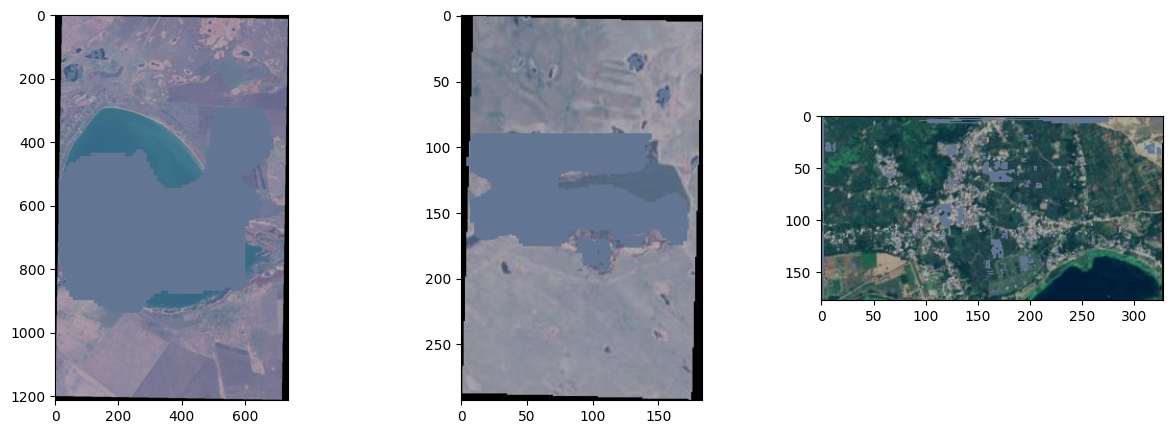

In [19]:
# Plotting some images with generated masks

indexes = [1, 26, 11]

nplots = len(indexes)
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots, 5))
for counter, idx in enumerate(indexes):
  example = train_dataset.examples[idx]
  image_orig = Image.open(example["image"])
  image_orig = np.asarray(image_orig)
  suffix = example["suffix"]
  render = render_example(image=image_orig, suffix=suffix)
  masked_output = render.get_mask()
  ax[counter].imshow(masked_output)


You can see that the generated masks are not perfect! Remember that we have ONLY 8 segmentation points that describe the shape of the water body (i.e. the `seg` points in the suffix part of the JSONL file). This can be seen as a limitation of the model to get accurate segmentation masks.

In [20]:
# # This peace of code is just to see the index of an image
# # in the JSONL format
# image_name = "water_body_7828.jpg"
# for idx in range(163):
#   example = train_dataset.examples[idx]
#   if image_name in example["image"]:
#     print(idx, example["image"])

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward. To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [21]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss


# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.

    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)


    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # print("tokens")
    # print([t for i, t in enumerate(tokens) if i ==0])
    # print("labels")
    # print([e["label"] for i, e in enumerate(examples) if i ==0])

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for several steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.


In [22]:
# Run a short training loop with cosine learning rate schedule.
#
# Note1: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#

%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 700
LEARNING_RATE = 0.004

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS =  TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1,
    base=LEARNING_RATE,
    decay_type="cosine",
    warmup_percent=0.10,
    )

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Check shapes of elements within examples
  # and print if shapes are inconsistent
  for key in examples[0].keys():
      shapes = [e[key].shape for e in examples]
      if len(set(shapes)) > 1:
          print(f"Inconsistent shapes for key '{key}': {shapes}")

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")


step:  1/87   lr: 0.00044   loss: 7.2740
step:  2/87   lr: 0.00089   loss: 7.3806
step:  3/87   lr: 0.00133   loss: 6.8214
step:  4/87   lr: 0.00178   loss: 6.3361
step:  5/87   lr: 0.00222   loss: 5.9899
step:  6/87   lr: 0.00267   loss: 6.1709
step:  7/87   lr: 0.00311   loss: 6.0668
step:  8/87   lr: 0.00356   loss: 5.5912
step:  9/87   lr: 0.00400   loss: 5.8295
step: 10/87   lr: 0.00400   loss: 5.3576
step: 11/87   lr: 0.00399   loss: 6.6902
step: 12/87   lr: 0.00399   loss: 5.7135
step: 13/87   lr: 0.00397   loss: 6.3791
step: 14/87   lr: 0.00396   loss: 8.1559
step: 15/87   lr: 0.00394   loss: 6.4759
step: 16/87   lr: 0.00392   loss: 5.9757
step: 17/87   lr: 0.00390   loss: 7.4070
step: 18/87   lr: 0.00387   loss: 5.8885
step: 19/87   lr: 0.00384   loss: 5.5245
step: 20/87   lr: 0.00381   loss: 5.7957
step: 21/87   lr: 0.00378   loss: 5.7450
step: 22/87   lr: 0.00374   loss: 5.3765
step: 23/87   lr: 0.00370   loss: 5.1414
step: 24/87   lr: 0.00365   loss: 5.1655
step: 25/87   lr

## Evaluate fine-tuned model

Finally we can see the predictions of the Paligemma on unseen data.

Two important notes:
* The resulting masks might not be exact due to the approximations made in the function `big_vision.evaluators.proj.paligemma.transfers.segmentation.segeval
`
* Sometimes, Paligemma predicts more or less than 16 segmentation tokens. Thus, we remove those predictions in the final result.


What we do here is to get the image names, true labels (the suffixes which contain the bounding boxhes, segmentation points and the label), and the predicted labels. Then, we remove the images that have more or less than 16 predictions tokens and finally we plot the results.  

In [23]:
# First, get a list of images, predictions, and true labels

nplots = len(test_dataset.examples)
counter = 0
image_names = []
true_masks = []
pred_masks = []

for nimage, true_label, prediction in make_predictions(test_data_iterator(), num_examples=nplots, batch_size=BATCH_SIZE):
  print(counter)
  print("true label:", true_label)
  print("prediction:", prediction)
  image_names.append(test_dataset.examples[counter]["image"])
  true_masks.append(true_label)
  pred_masks.append(prediction)
  counter +=1


0
true label: <loc0822><loc0759><loc1001><loc1018><seg103><seg095><seg109><seg106><seg117><seg110><seg123><seg117><seg110><seg123><seg106><seg115><seg111><seg117><seg114><seg112> water; <loc0804><loc0991><loc0845><loc1018><seg101><seg126><seg102><seg125><seg103><seg126><seg104><seg125><seg105><seg124><seg105><seg127><seg102><seg127><seg101><seg126> water; <loc0402><loc0905><loc0512><loc1007><seg050><seg115><seg054><seg113><seg058><seg117><seg061><seg121><seg063><seg125><seg057><seg123><seg056><seg121><seg054><seg117> water; <loc0169><loc0021><loc0836><loc1013><seg077><seg125><seg030><seg071><seg029><seg058><seg040><seg063><seg049><seg026><seg073><seg009><seg084><seg049><seg091><seg088> water; <loc0004><loc0948><loc0050><loc0991><seg001><seg119><seg003><seg119><seg005><seg119><seg005><seg121><seg006><seg121><seg005><seg122><seg001><seg123><seg001><seg121> water

prediction: 
1
true label: <loc0286><loc0248><loc0871><loc0939><seg038><seg031><seg050><seg037><seg045><seg060><seg087><seg079

In [24]:
# get the faulty indexes and remove them from the predictions

idx_faulty_suffix = []

for idx in range(len(image_names)):
  suffix = pred_masks[idx]
  if "<loc" in suffix:
    image_names[idx]

    image_orig = Image.open(image_names[idx])
    image_orig = np.asarray(image_orig)

    render = render_example(image = image_orig,
                              suffix = suffix,
                              )
    segments = render.segments

    # see if there are segments with +/- 16 points
    filtered_segments = [len(s) for s in segments if len(s) != 16]

    if len(filtered_segments) >= 1:
      idx_faulty_suffix.append(idx)


print("faulty index", idx_faulty_suffix)

idx_faulty_suffix.sort(reverse=True)
for index in idx_faulty_suffix:
  del image_names[index]
  del true_masks[index]
  del pred_masks[index]


faulty index [3, 8, 9, 11]


0
Shapes of segments: [(16,), (16,), (16,), (16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 64, 1)]


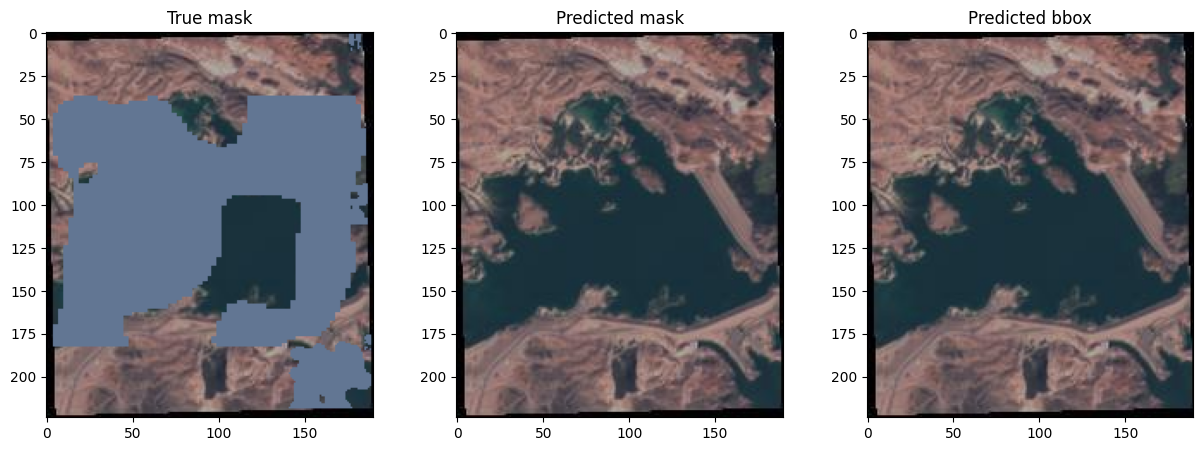

1
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


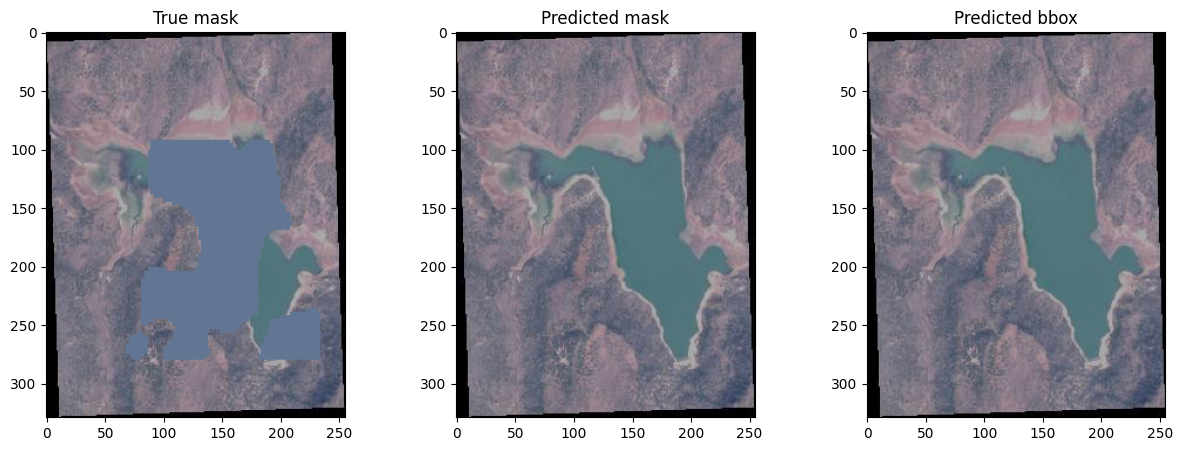

2
Shapes of segments: [(16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1)]


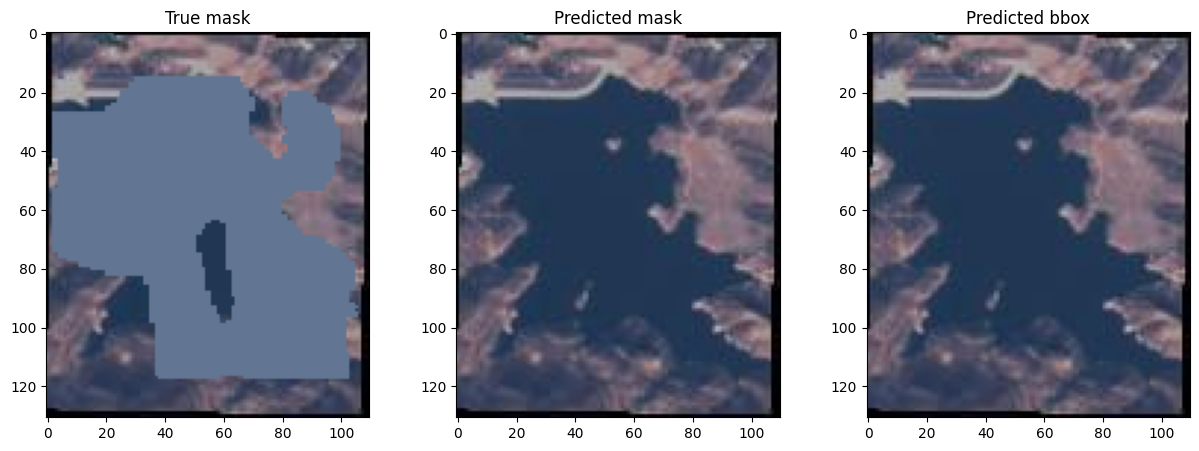

3
Shapes of segments: [(16,), (16,), (16,), (16,), (16,), (8,)]
4
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


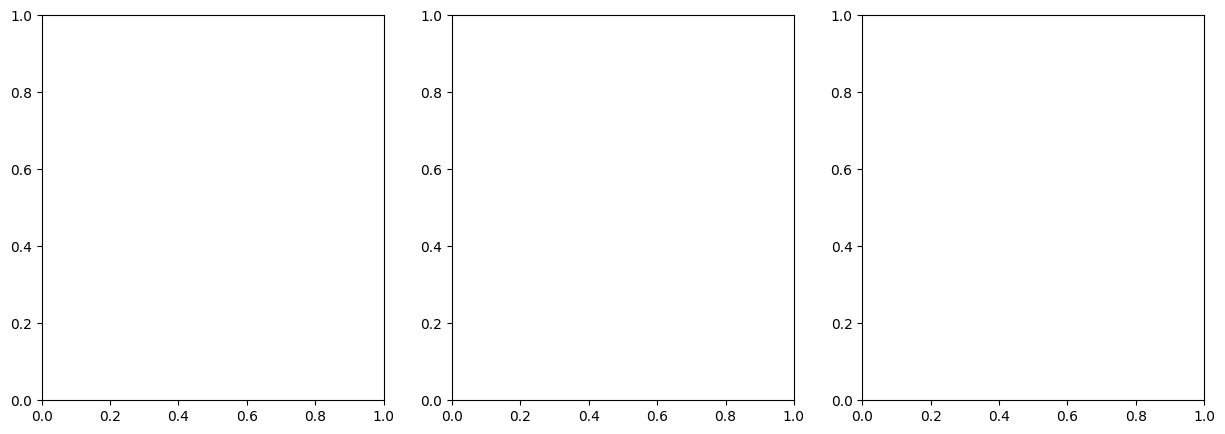

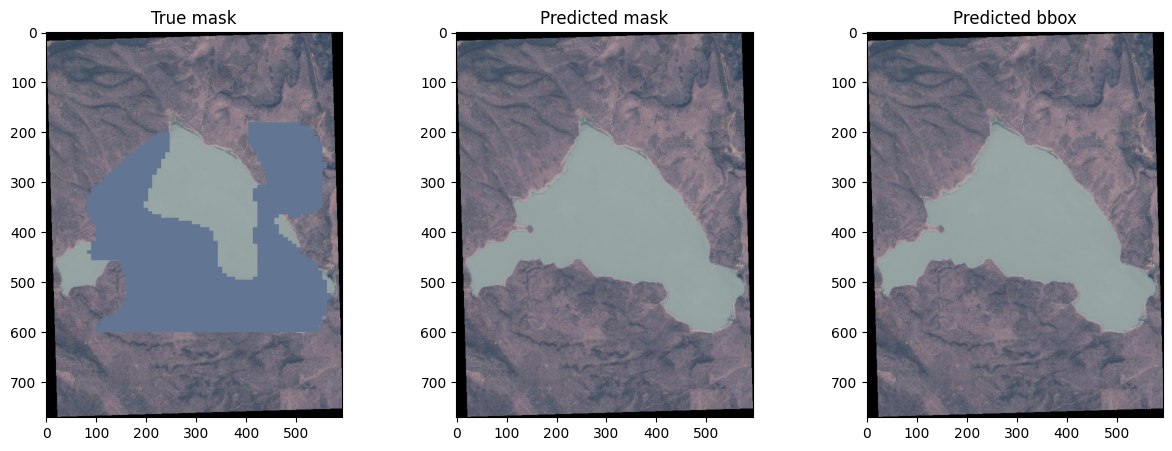

5
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


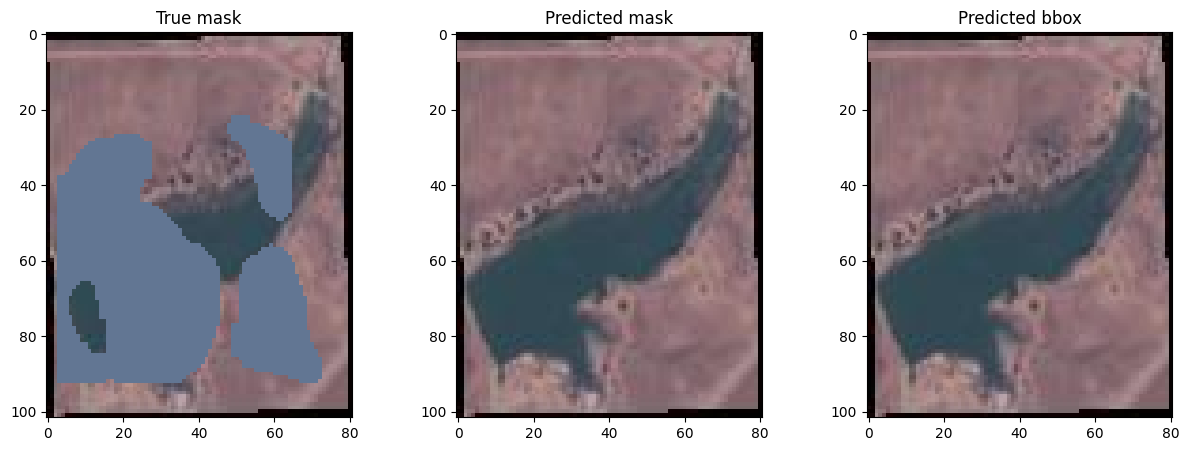

6
Shapes of segments: [(16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1)]


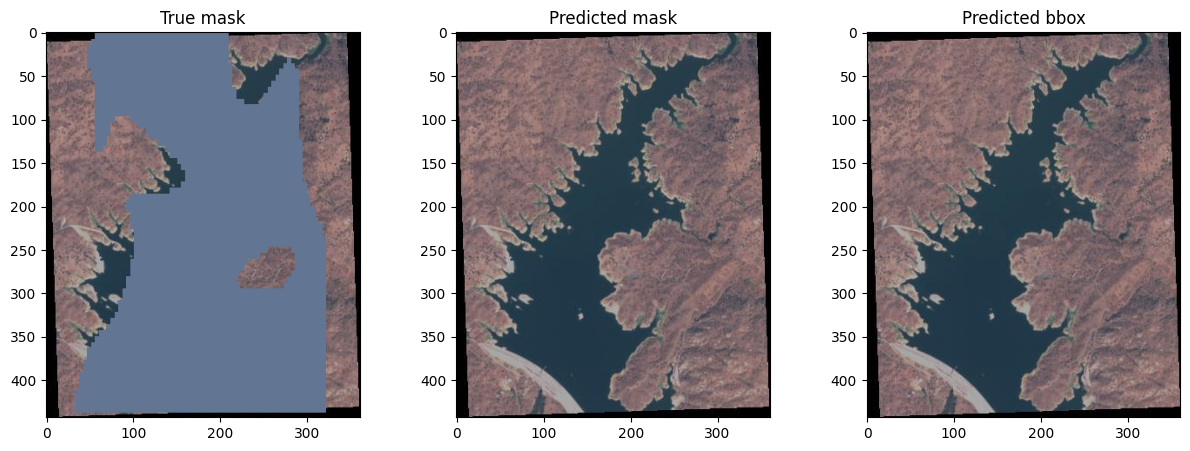

7
Shapes of segments: [(16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1)]


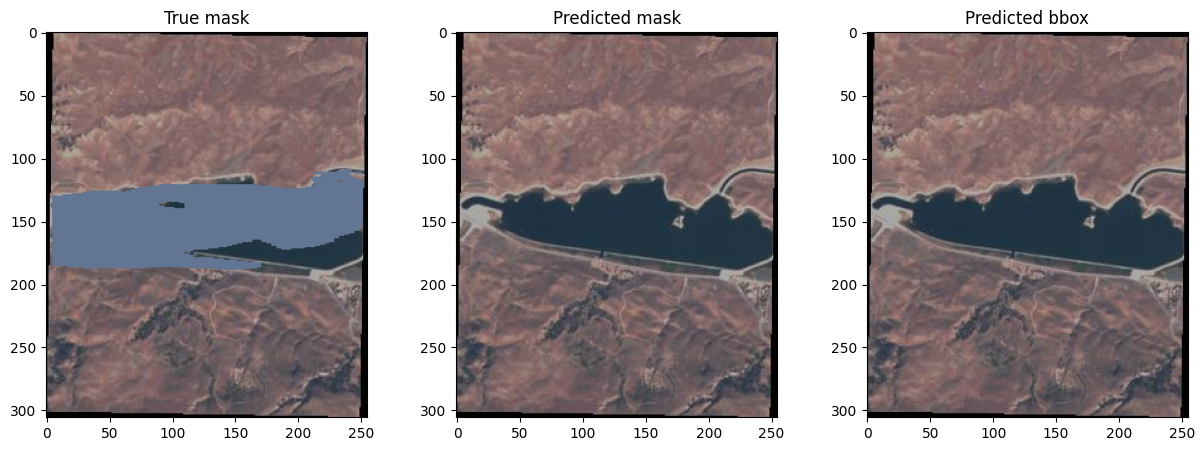

8
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


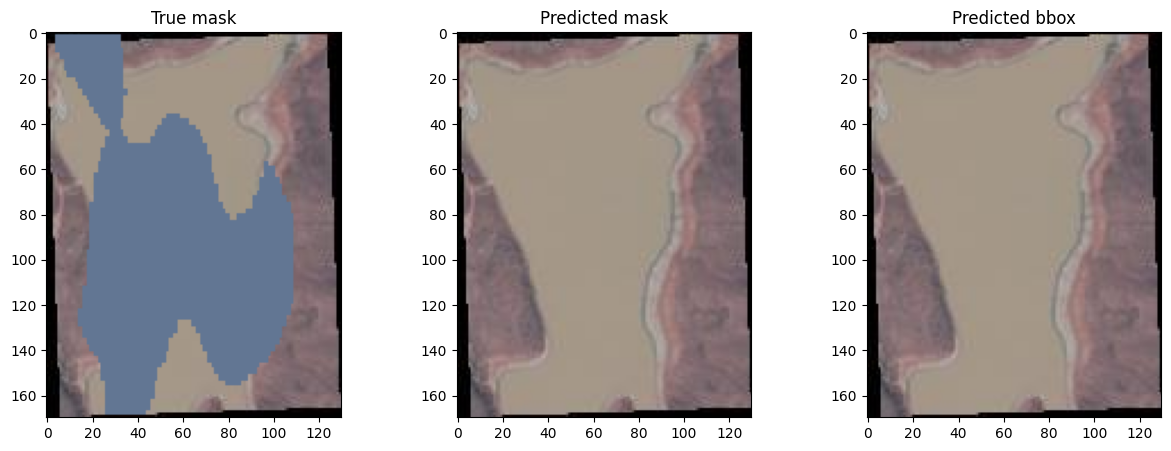

9
Shapes of segments: [(16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1)]


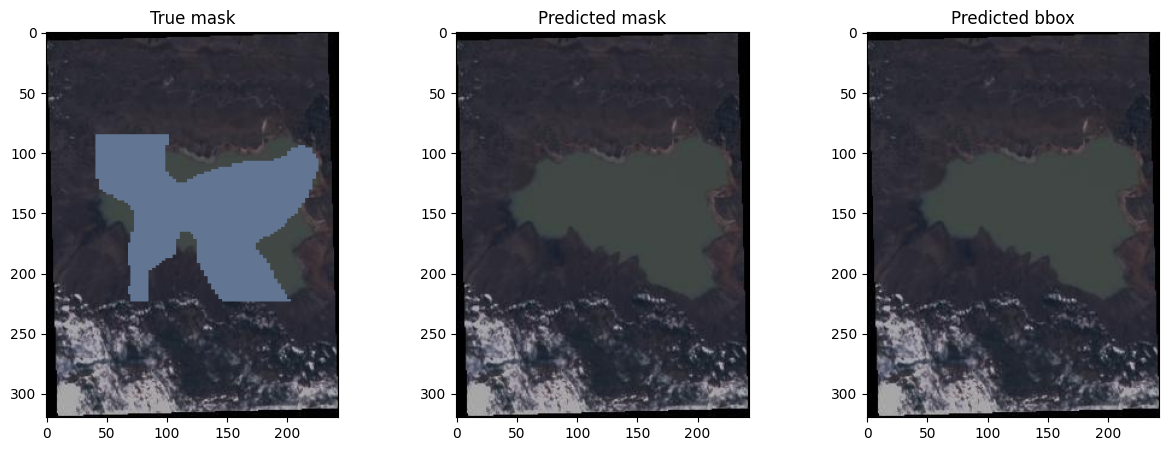

10
Shapes of segments: [(16,), (16,)]
Shapes of reconstructed masks: [(64, 64, 1), (64, 64, 1)]


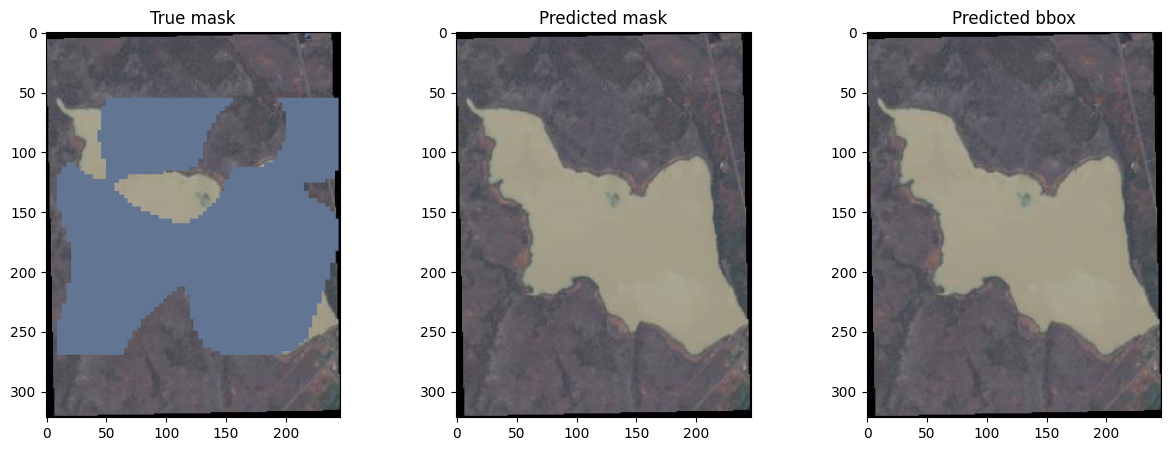

11


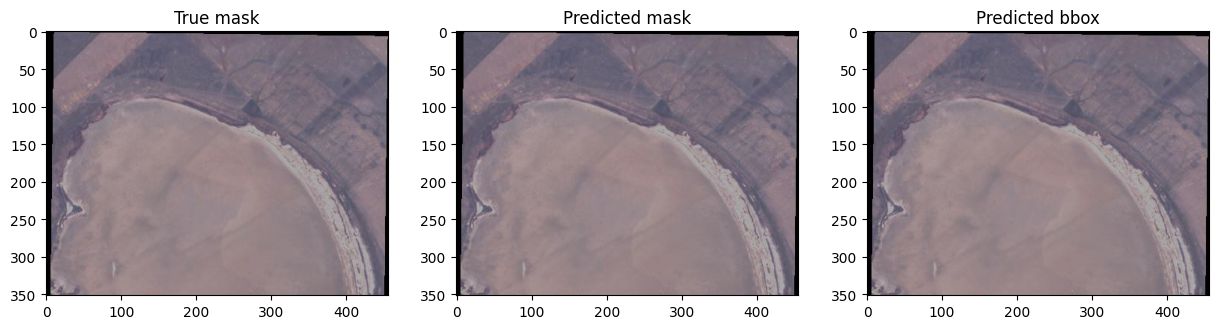

12
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


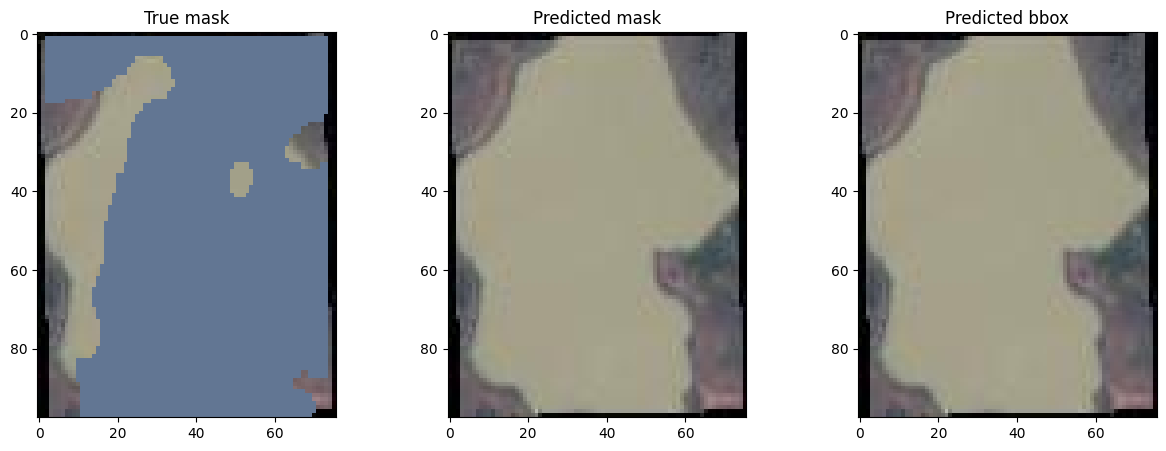

13
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


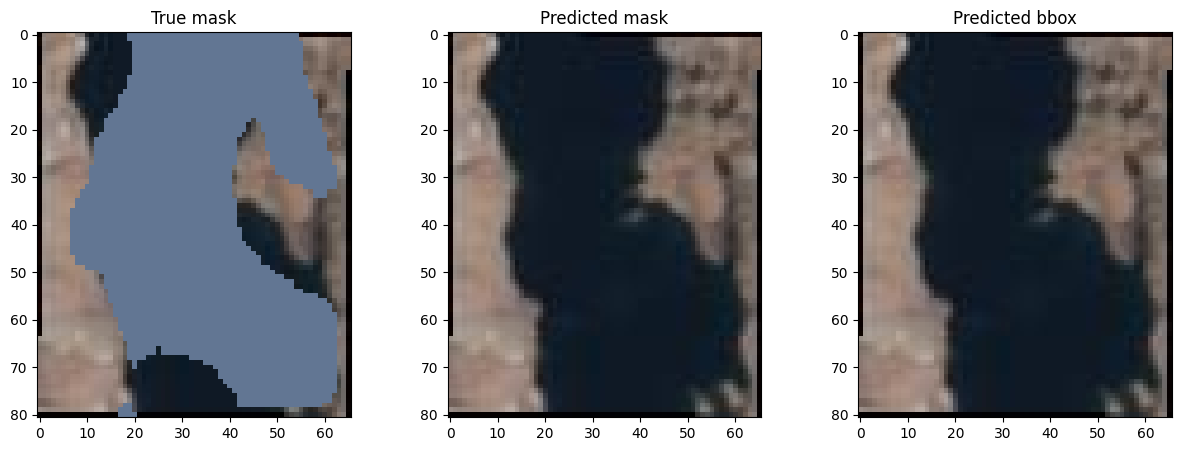

14
Shapes of segments: [(16,)]
Shapes of reconstructed masks: [(64, 64, 1)]


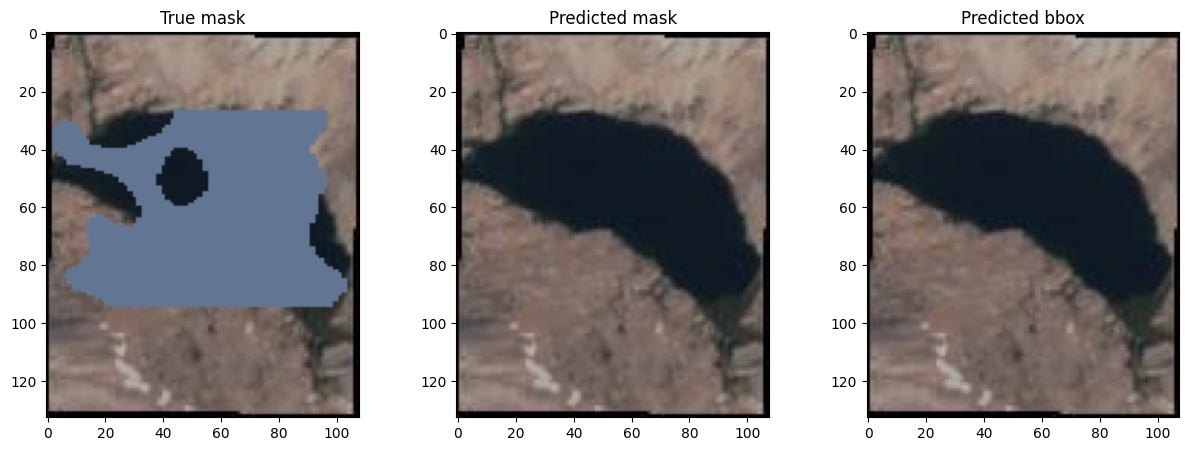

In [25]:
# Finally, plot the results

for idx in range(len(image_names)):
  try:
    print(idx)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    image_orig = Image.open(image_names[idx])
    image_orig = np.asarray(image_orig)

    render_true = render_example(image = image_orig,
                              suffix = true_masks[idx],
                              )

    true_mask = render_true.get_mask()

    render_pred = render_example(image = image_orig,
                              suffix = pred_masks[idx],
                              )
    predicted_mask = render_pred.get_mask()

    ax[0].imshow(true_mask)
    ax[0].set_title("True mask")
    ax[1].imshow(predicted_mask)
    ax[1].set_title("Predicted mask")
    render_pred.get_bbox(ax[2])
    ax[2].set_title("Predicted bbox")
    plt.show()
  except:
    continue


## Save fine-tuned model locally

A Paligemma model can have a size of 5GB. Make sure you have this storage in your Drive account.

In [26]:
if SAVE_MODEL:

  TARGET_MODEL_DIR = os.path.join(root_path, "finetuned_model")
  TARGET_MODEL_NAME = os.path.join(TARGET_MODEL_DIR, "paligemma-seg-3b-pt-224.f16.npz")

  os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

  flat, _ = big_vision.utils.tree_flatten_with_names(params)
  with open(TARGET_MODEL_NAME, "wb") as f:
    np.savez(f, **{k: v for k, v in flat})

# Congratulations
This is the end of the notebook